# **Постановка задачи**
### Предсказание значений временного ряда из группы временных рядов, который меняется с временным отставанием от других рядов.

In [1]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots for God of plots

from sklearn.compose import TransformedTargetRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

sns.set()
%matplotlib inline

# Про данные  
#### Наша задача осложнена тем что мы не знаем ни временной ряд, который отстает, ни период его отставания
#### Для упрощения задачи возмем цены закрытия по фондовым индексам за год с периодичностью в один день.
#### Мы будем искать фондовый индекс, который отстает от других на 1 день. Мы не знаем есть ли он вообще!

In [2]:
#Проверим что пришло с Yahoo
df = pd.read_csv('data/csv/^NDX.csv', index_col=['Date'], parse_dates=['Date'])
df.shape

(251, 1)

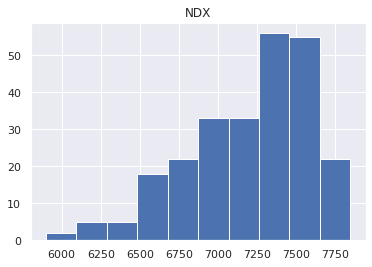

In [3]:
df.hist()
plt.show();

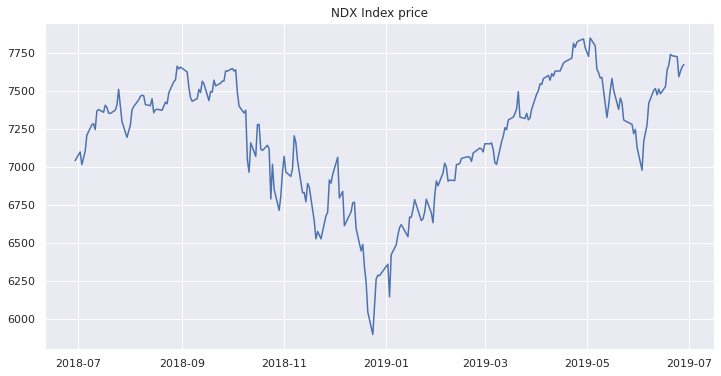

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(df)
plt.title('NDX Index price')
plt.grid(True)
plt.show();

In [5]:
#Выбросим колонку, что бы получить пустой датасет с индексами
df_blank = df.drop('NDX', axis=1).copy()
df_blank.head()

""
Date
2018-06-29
2018-07-02
2018-07-03
2018-07-05
2018-07-06


In [6]:
# Пройдемся по словарю с тикерами и соберем все данные из сохраненных файлов
from tickers import tickers_dict

In [7]:
df_base = df_blank.copy()

for ticker in tickers_dict.values():
    ticker_data = pd.read_csv('data/csv/'+ticker[0]+'.csv', index_col=['Date'], parse_dates=['Date'])
    
    df_base = pd.concat([df_base,ticker_data], axis=1)

In [8]:
df_base.head()

,IXIC,BANK,NBI,IXCO,IXHC,INDS,INSR,OFIN,IXTC,TRAN,DJI,NYA
Date,,,,,,,,,,,,
2018-06-29,7510.299805,4133.069824,3453.429932,4455.100098,809.880005,6109.169922,8046.700195,8219.429688,353.329987,5228.930176,24271.410156,12504.250000
2018-07-02,7567.689941,4174.770020,3484.419922,4504.459961,816.690002,6133.229980,8072.609863,8255.740234,353.040009,5270.200195,24307.179688,12485.580078
2018-07-03,7502.669922,4164.910156,3487.419922,4435.979980,818.669983,6098.649902,8094.189941,8212.250000,351.940002,5232.060059,24174.820312,12494.700195
2018-07-05,7586.430176,4186.109863,3525.399902,4505.930176,826.469971,6147.930176,8142.890137,8264.040039,353.480011,5253.290039,24356.740234,12585.209961
2018-07-06,7688.390137,4211.459961,3656.500000,4571.319824,849.260010,6207.439941,8218.480469,8313.500000,356.589996,5283.830078,24456.480469,12664.879883


# Создадим несколько датасетов  

## **df_lags** - датасет с временными сдвигами

In [9]:
lag_list = [1, 2, 3, 4]

In [10]:
df_lags = df_blank.copy()

for name, column in df_base.iteritems():
    for lag in lag_list:
        df_lags = pd.concat([df_lags, column.shift(lag).rename(name+'_l'+str(lag), inplace = True)], axis='columns')

In [11]:
df_lags.head()

,IXIC_l1,IXIC_l2,IXIC_l3,IXIC_l4,BANK_l1,BANK_l2,BANK_l3,BANK_l4,NBI_l1,NBI_l2,...,TRAN_l3,TRAN_l4,DJI_l1,DJI_l2,DJI_l3,DJI_l4,NYA_l1,NYA_l2,NYA_l3,NYA_l4
Date,,,,,,,,,,,,,,,,,,,,,
2018-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-02,7510.299805,NaN,NaN,NaN,4133.069824,NaN,NaN,NaN,3453.429932,NaN,...,NaN,NaN,24271.410156,NaN,NaN,NaN,12504.250000,NaN,NaN,NaN
2018-07-03,7567.689941,7510.299805,NaN,NaN,4174.770020,4133.069824,NaN,NaN,3484.419922,3453.429932,...,NaN,NaN,24307.179688,24271.410156,NaN,NaN,12485.580078,12504.250000,NaN,NaN
2018-07-05,7502.669922,7567.689941,7510.299805,NaN,4164.910156,4174.770020,4133.069824,NaN,3487.419922,3484.419922,...,5228.930176,NaN,24174.820312,24307.179688,24271.410156,NaN,12494.700195,12485.580078,12504.250000,NaN
2018-07-06,7586.430176,7502.669922,7567.689941,7510.299805,4186.109863,4164.910156,4174.770020,4133.069824,3525.399902,3487.419922,...,5270.200195,5228.930176,24356.740234,24174.820312,24307.179688,24271.410156,12585.209961,12494.700195,12485.580078,12504.25


In [12]:
df_lags = df_lags.dropna()
df_lags.shape

(247, 48)

## **df_relative_lags** - датасет с относительными изменениями, но так же с временными сдвигами

In [13]:
df_relative_lags = df_blank.copy()

#Вычисляем относительные изменения за единицу времени (1 день) и добавляем их со сдвигом
for name, column in df_base.iteritems():
    for lag in lag_list:
        df_relative_lags = pd.concat([df_relative_lags, (column / column.shift(1) - 1).shift(lag).rename(name+'_rl'+str(lag), inplace = True)], axis='columns')

In [14]:
df_relative_lags.head()

,IXIC_rl1,IXIC_rl2,IXIC_rl3,IXIC_rl4,BANK_rl1,BANK_rl2,BANK_rl3,BANK_rl4,NBI_rl1,NBI_rl2,...,TRAN_rl3,TRAN_rl4,DJI_rl1,DJI_rl2,DJI_rl3,DJI_rl4,NYA_rl1,NYA_rl2,NYA_rl3,NYA_rl4
Date,,,,,,,,,,,,,,,,,,,,,
2018-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-03,0.007642,NaN,NaN,NaN,0.010089,NaN,NaN,NaN,0.008974,NaN,...,NaN,NaN,0.001474,NaN,NaN,NaN,-0.001493,NaN,NaN,NaN
2018-07-05,-0.008592,0.007642,NaN,NaN,-0.002362,0.010089,NaN,NaN,0.000861,0.008974,...,NaN,NaN,-0.005445,0.001474,NaN,NaN,0.000730,-0.001493,NaN,NaN
2018-07-06,0.011164,-0.008592,0.007642,NaN,0.005090,-0.002362,0.010089,NaN,0.010891,0.000861,...,0.007893,NaN,0.007525,-0.005445,0.001474,NaN,0.007244,0.000730,-0.001493,NaN


In [15]:
df_relative_lags = df_relative_lags.dropna()
df_relative_lags.shape

(246, 48)

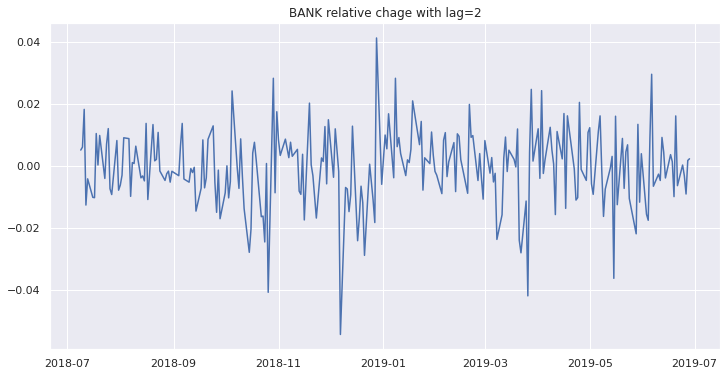

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(df_relative_lags['BANK_rl2'])
plt.title('BANK relative chage with lag=2')
plt.grid(True)
plt.show();

## **df_varied_relative** - датасет относительными изменениями за разный промежуток времени

In [17]:
df_varied_relative = df_blank.copy()

#Вычисляем относительные изменения за разные промежутки времени и добавляем их со сдвигом 1
for name, column in df_base.iteritems():
    for lag in lag_list:
        df_varied_relative = pd.concat([df_varied_relative, (column.shift(1) / column.shift(lag+1) - 1).rename(name+'_vr'+str(lag), inplace = True)], axis='columns')

In [18]:
df_varied_relative.head()

,IXIC_vr1,IXIC_vr2,IXIC_vr3,IXIC_vr4,BANK_vr1,BANK_vr2,BANK_vr3,BANK_vr4,NBI_vr1,NBI_vr2,...,TRAN_vr3,TRAN_vr4,DJI_vr1,DJI_vr2,DJI_vr3,DJI_vr4,NYA_vr1,NYA_vr2,NYA_vr3,NYA_vr4
Date,,,,,,,,,,,,,,,,,,,,,
2018-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-03,0.007642,NaN,NaN,NaN,0.010089,NaN,NaN,NaN,0.008974,NaN,...,NaN,NaN,0.001474,NaN,NaN,NaN,-0.001493,NaN,NaN,NaN
2018-07-05,-0.008592,-0.001016,NaN,NaN,-0.002362,0.007704,NaN,NaN,0.000861,0.009842,...,NaN,NaN,-0.005445,-0.003980,NaN,NaN,0.000730,-0.000764,NaN,NaN
2018-07-06,0.011164,0.002476,0.010137,NaN,0.005090,0.002716,0.012833,NaN,0.010891,0.011761,...,0.004659,NaN,0.007525,0.002039,0.003516,NaN,0.007244,0.007980,0.006475,NaN


In [19]:
df_varied_relative = df_varied_relative.dropna()
df_varied_relative.shape

(246, 48)

## **df_targets** - датасет с целевыми переменными (пока не знаем какие нам понадобяться)

In [20]:
df_targets = df_base.copy()
df_targets.shape

(251, 12)

## **df_targets_relative** - датасет с относительными изменениями целевых переменных
Ведь если нам нужно узнать цену на завтра, нам можно предсказывать её изменение относительно значения сегодня.

In [21]:
df_targets_relative = df_blank.copy()

#Вычисляем относительные изменения за единицу времени и оставляем их без сдвига
for name, column in df_base.iteritems():
    df_targets_relative = pd.concat([df_targets_relative, (column / column.shift(1) - 1)], axis='columns')

In [22]:
df_targets_relative.head()

,IXIC,BANK,NBI,IXCO,IXHC,INDS,INSR,OFIN,IXTC,TRAN,DJI,NYA
Date,,,,,,,,,,,,
2018-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-02,0.007642,0.010089,0.008974,0.011079,0.008409,0.003938,0.003220,0.004418,-0.000821,0.007893,0.001474,-0.001493
2018-07-03,-0.008592,-0.002362,0.000861,-0.015203,0.002424,-0.005638,0.002673,-0.005268,-0.003116,-0.007237,-0.005445,0.000730
2018-07-05,0.011164,0.005090,0.010891,0.015769,0.009528,0.008081,0.006017,0.006306,0.004376,0.004058,0.007525,0.007244
2018-07-06,0.013440,0.006056,0.037187,0.014512,0.027575,0.009680,0.009283,0.005985,0.008798,0.005814,0.004095,0.006330


In [23]:
df_targets_relative.shape

(251, 12)

### Обрежем все датасеты по самому короткому

In [24]:
df_lags = df_lags.loc[df_relative_lags.index]
#df_relative_lags
#df_varied_relative  - они самы короткие, по ним и обрезаем
df_targets = df_targets.loc[df_relative_lags.index]
df_targets_relative = df_targets_relative.loc[df_relative_lags.index]

In [25]:
df_targets.shape

(246, 12)

In [26]:
df_targets.head(1)

,IXIC,BANK,NBI,IXCO,IXHC,INDS,INSR,OFIN,IXTC,TRAN,DJI,NYA
Date,,,,,,,,,,,,
2018-07-09,7756.200195,4288.25,3676.800049,4612.919922,854.289978,6260.629883,8371.30957,8381.450195,357.019989,5384.549805,24776.589844,12776.919922


In [27]:
df_targets.tail(1)

,IXIC,BANK,NBI,IXCO,IXHC,INDS,INSR,OFIN,IXTC,TRAN,DJI,NYA
Date,,,,,,,,,,,,
2019-06-28,8006.240234,3677.47998,3427.98999,4821.259766,830.22998,6559.220215,10093.080078,8887.490234,415.929993,5144.120117,26599.960938,13049.709961


## Разделим данные на TRAIN и TEST

In [28]:
X_lags_tr, X_lags_te, X_rlags_tr, X_rlags_te, X_variedr_tr, X_variedr_te, Y_tr, Y_te, Y_rlags_tr, Y_rlags_te = train_test_split(df_lags, 
                                                                                                                                df_relative_lags, 
                                                                                                                                df_varied_relative, 
                                                                                                                                df_targets,
                                                                                                                                df_targets_relative,
                                                                                                                                test_size=0.2, shuffle=False)
# Чтобы легче ориентироваться:
# X - фичи, Y - целевые значения
# rlags -relative lags, variedr - varied relative
# tr -train, te - test

In [29]:
X_lags_tr.tail(1)

,IXIC_l1,IXIC_l2,IXIC_l3,IXIC_l4,BANK_l1,BANK_l2,BANK_l3,BANK_l4,NBI_l1,NBI_l2,...,TRAN_l3,TRAN_l4,DJI_l1,DJI_l2,DJI_l3,DJI_l4,NYA_l1,NYA_l2,NYA_l3,NYA_l4
Date,,,,,,,,,,,,,,,,,,,,,
2019-04-17,8000.22998,7976.009766,7984.160156,7947.359863,3738.419922,3679.01001,3730.23999,3668.280029,3439.709961,3470.909912,...,5287.029785,5245.439941,26452.660156,26384.769531,26412.300781,26143.050781,12952.240234,12956.679688,12969.540039,12887.120117


#### В обучающей выборке у нас данные за почти 10 месяцев, в тренировочной - чуть больше чем за 2 месяца.

## **EDA**
#### Посмотрим на тренировочные данные и попробуем сделать первые выводы

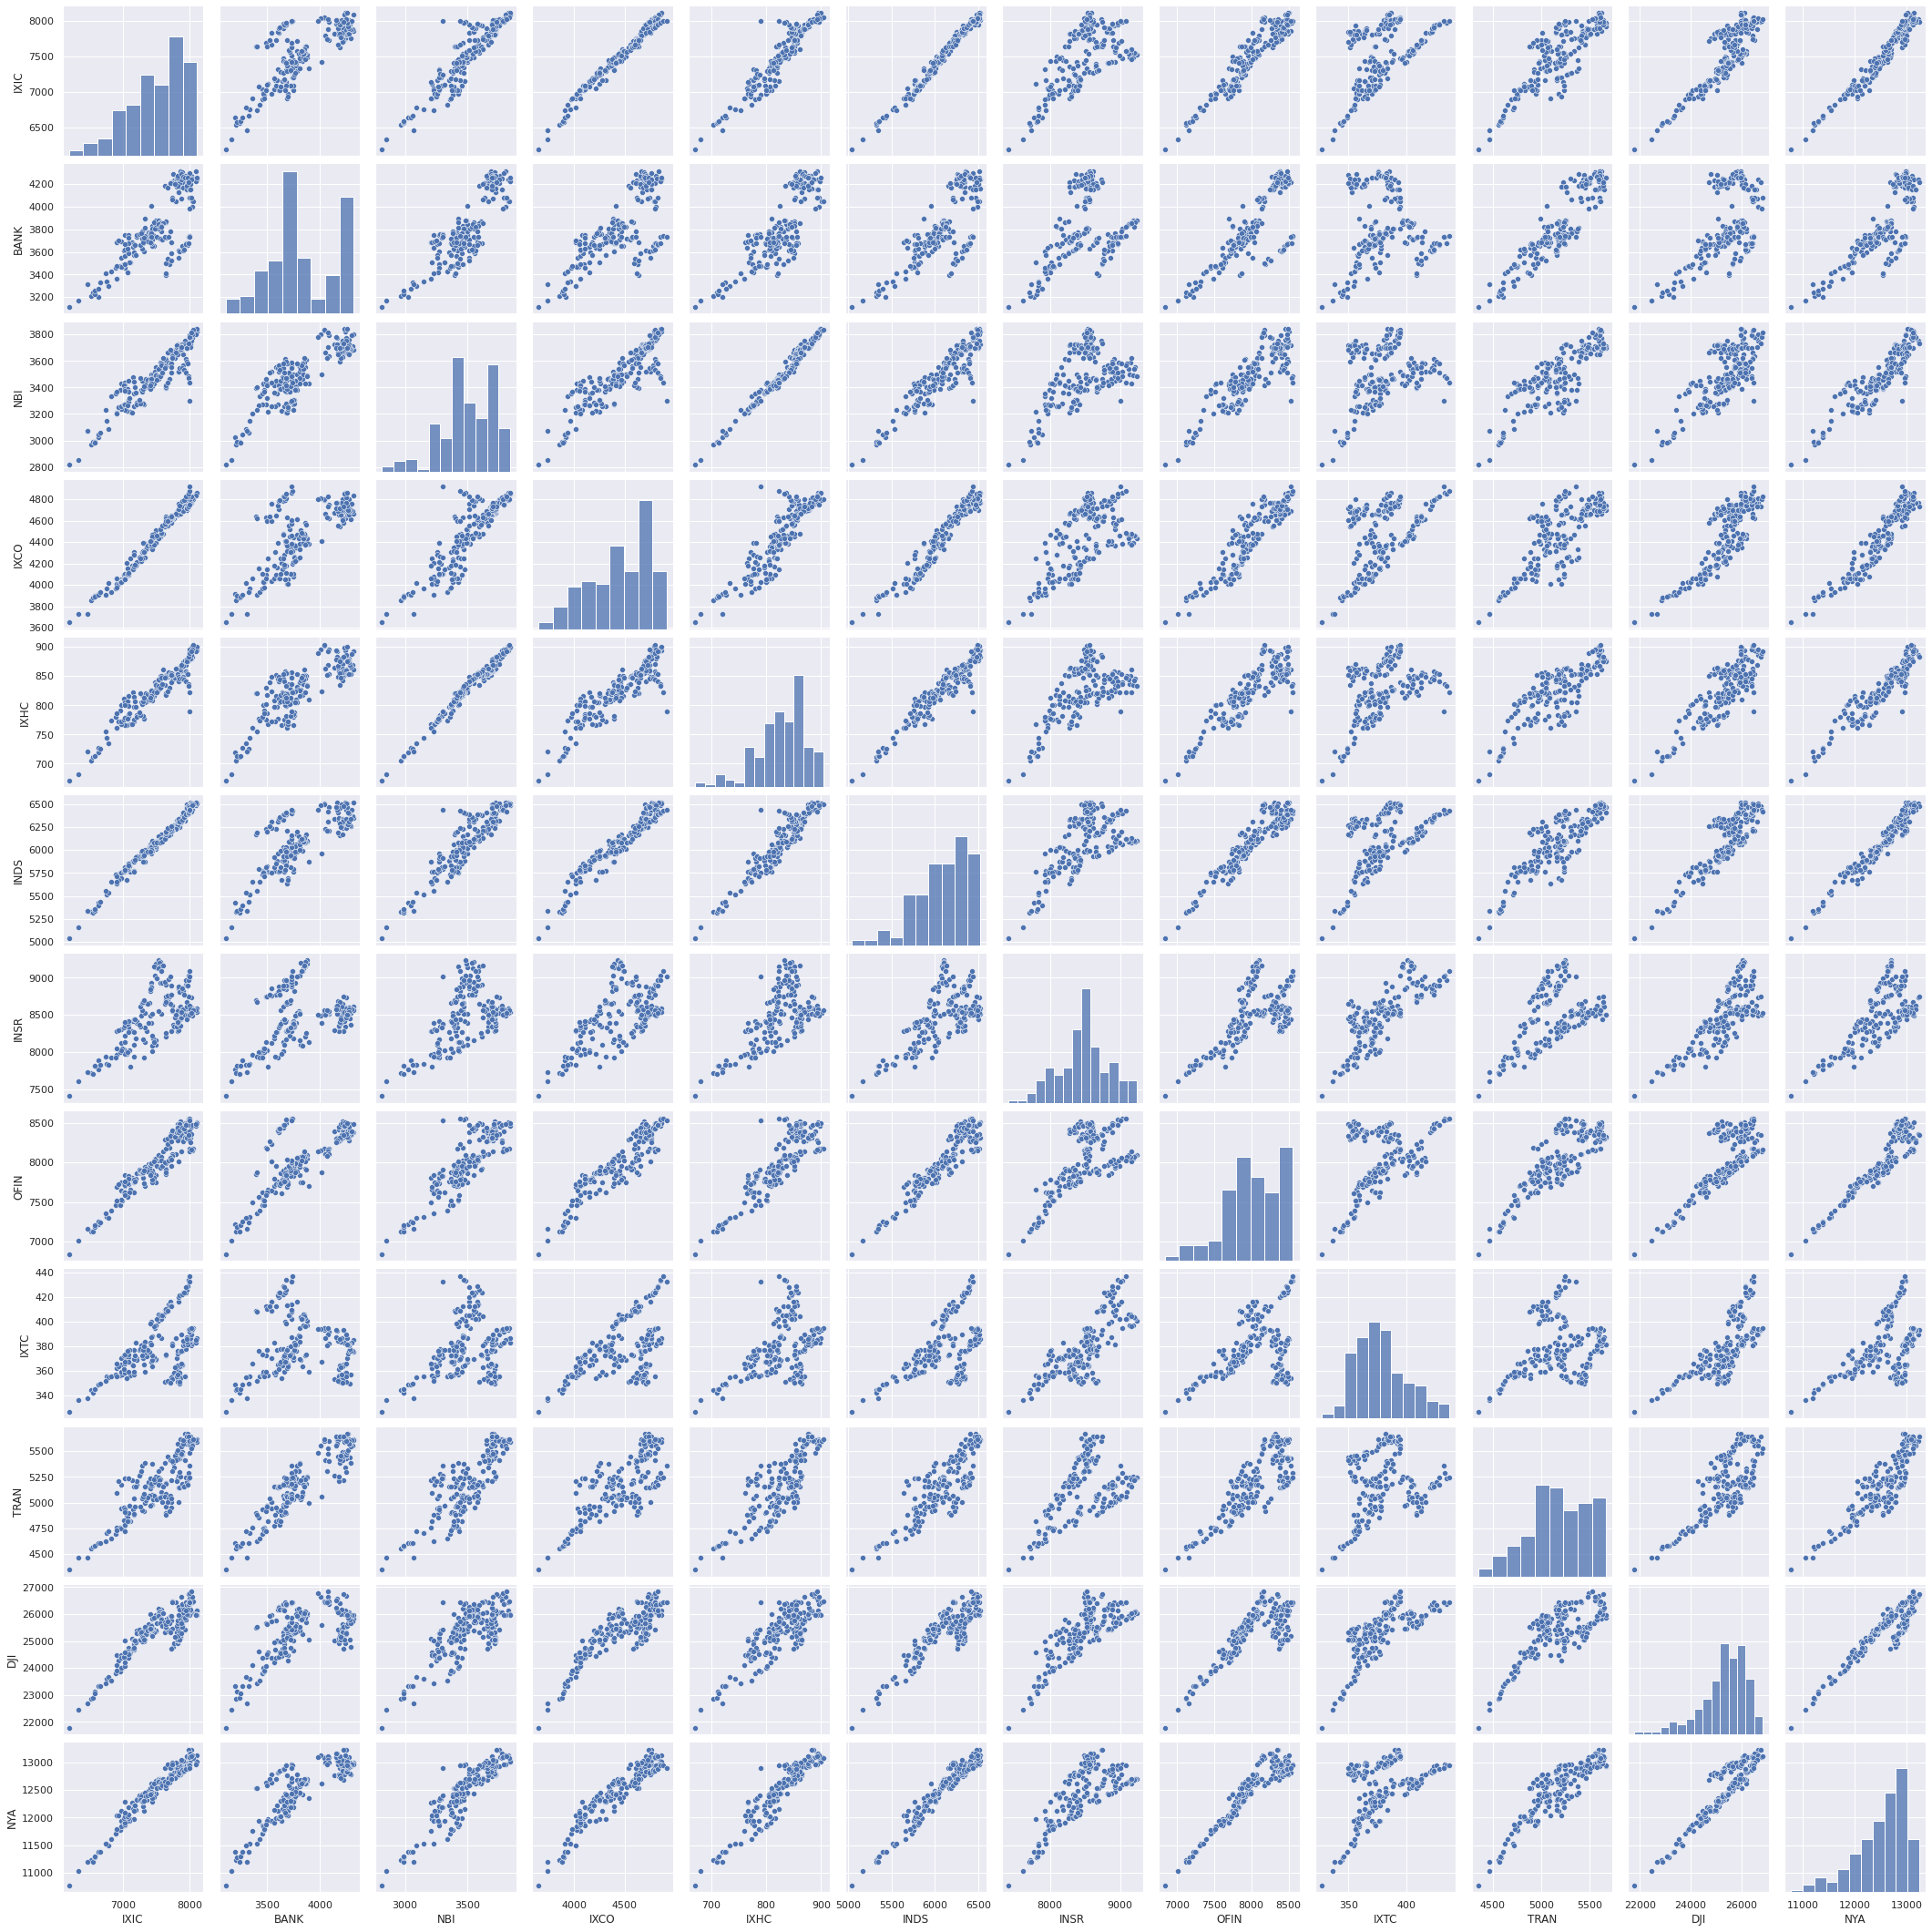

In [30]:
y_vars = Y_tr.columns
tmp_df = Y_tr[y_vars].copy()

%config InlineBackend.figure_format = 'png' 
sns.pairplot(tmp_df);

#### Данные распределены не совсем нормально, будем пробовать применить преобразование из семейства Power Transform, но позже, пока не трогаем.
#### Сдвиги не смотрим, они будут распределены так же.

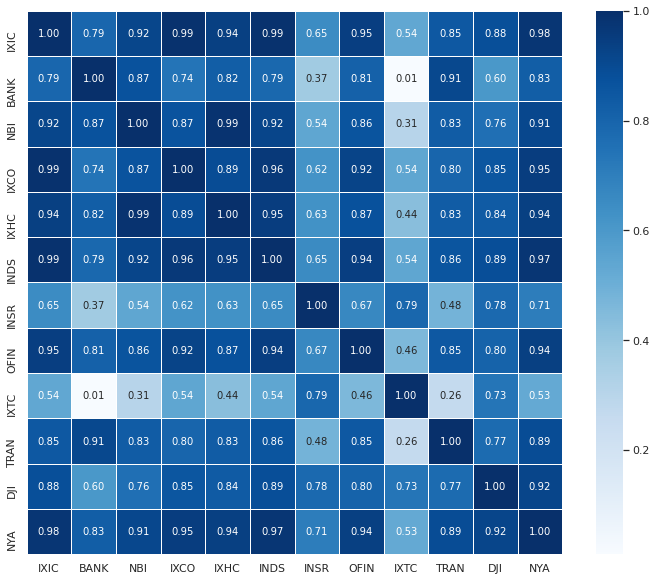

In [31]:
plt.figure(figsize = (12,10))
sns.heatmap((Y_tr).corr(), annot=True, fmt='.2f', cmap='Blues', linecolor='white', linewidths=1);

#### Присутствует мультиколлинеарность между факторами, и нам нужно понижать размерность.  
#### Добавление сдвигов картину не меняет.  
#### Позже попробуем применить метод главных компанент (PCA).

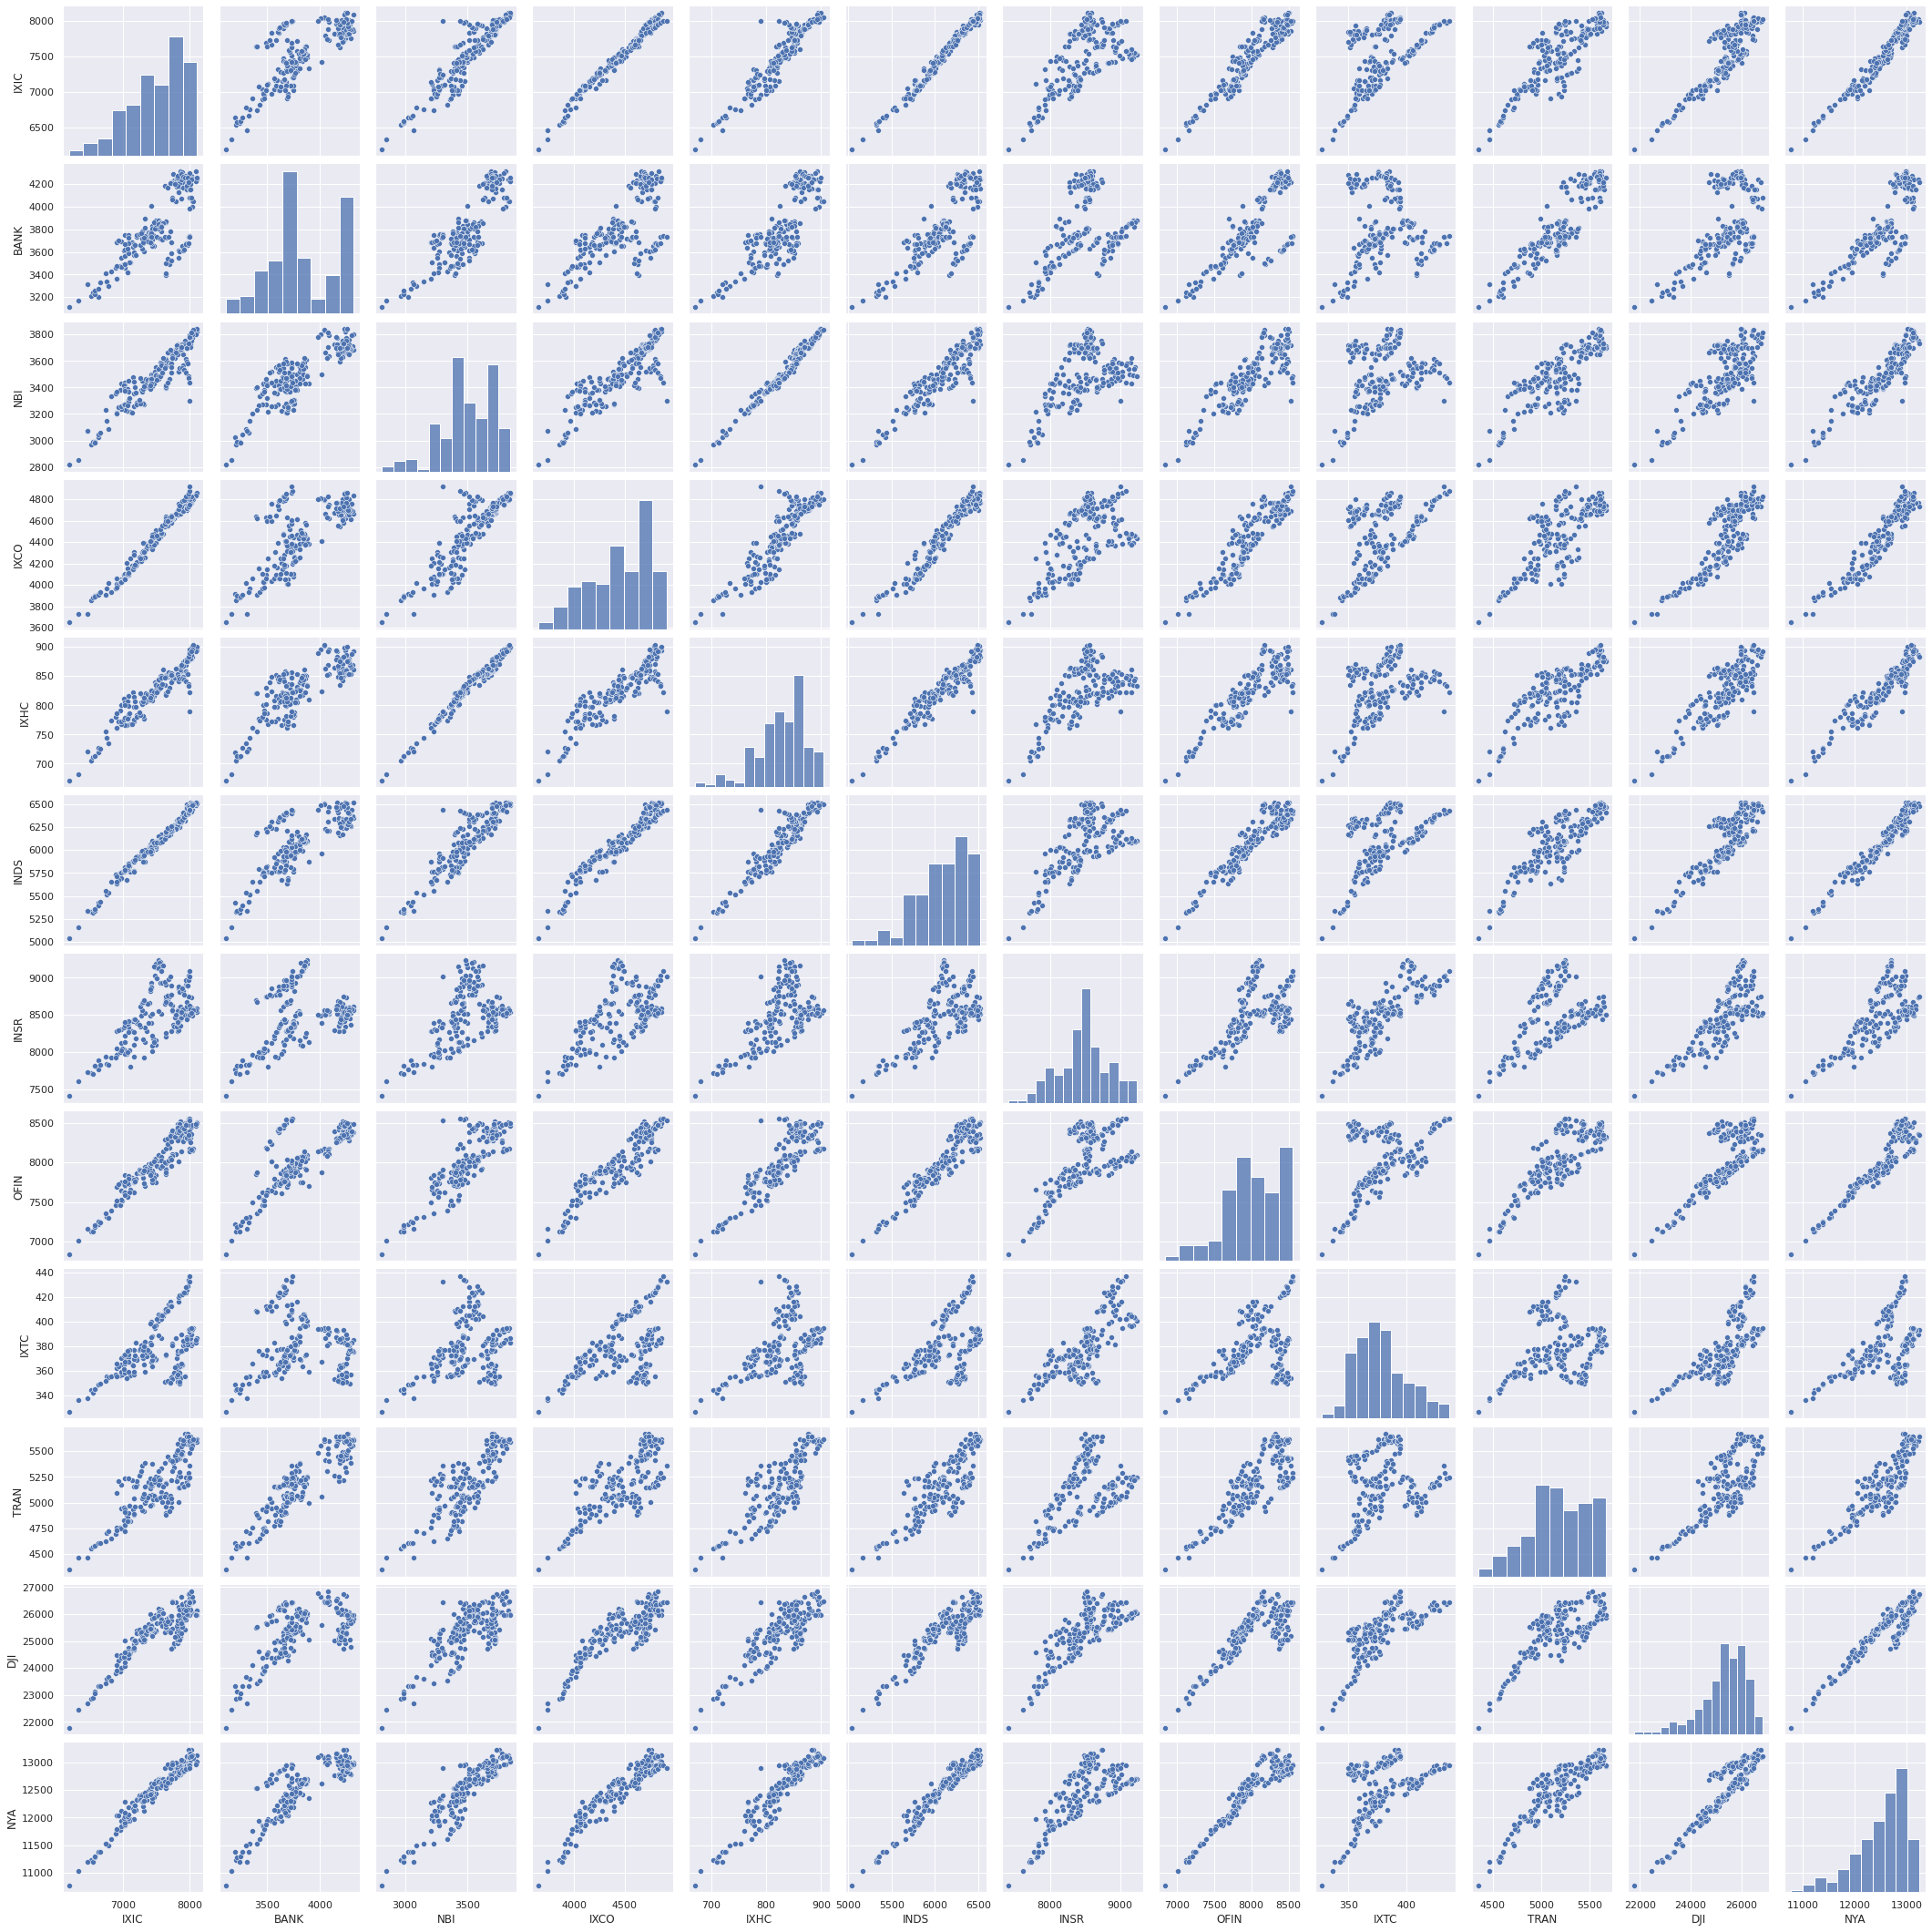

In [32]:
y_vars = Y_tr.columns
tmp_df = Y_tr[y_vars].copy()

%config InlineBackend.figure_format = 'png' 
sns.pairplot(tmp_df);

#### А вот у относительных изменений с нормальностью все в порядке.

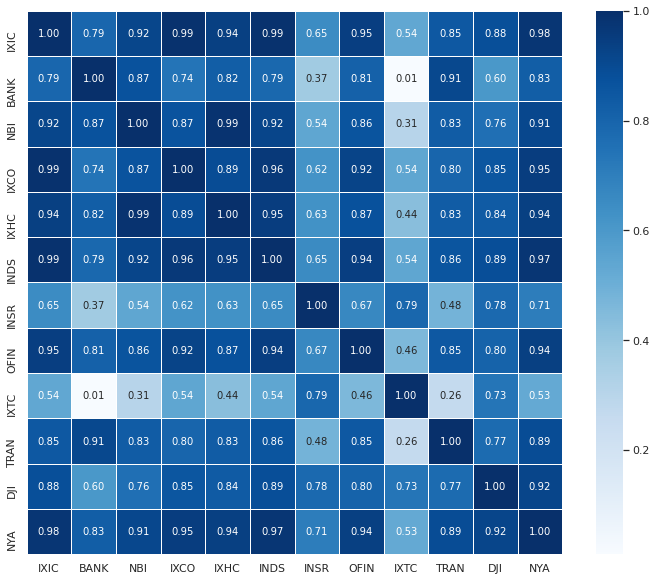

In [33]:
plt.figure(figsize = (12,10))
sns.heatmap((Y_tr).corr(), annot=True, fmt='.2f', cmap='Blues', linecolor='white', linewidths=1);

#### И мультиколлинеарность менее выраженная.  
#### Можно попробовать прологарифмировать, чтобы чут-чуть убрать хвосты.  

# **Построение моделей**
#### Преобразование данных будем делать для каждой модели отдельно

In [34]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [35]:
# Выберем почти наугад, что будем предсказывать
targets_list = ['IXIC',
                'IXTC',
                'IXHC',
                'NYA']

In [36]:
for t in targets_list:
    print(t + ' : '+tickers_dict[t][1])

IXIC : NASDAQ Composite
IXTC : NASDAQ Telecommunications
IXHC : NASDAQ HealthCare
NYA : NYSE COMPOSITE (DJ)


In [37]:
# Сюда сохраняем метрики
results_dict = dict()
results_relative_dict = dict()

In [38]:
def model_target_metrics(y_true, y_pred, metrics_round=4):
    mt_metrics = {'RMSE': np.around(mean_squared_error(y_true, y_pred, squared=False), decimals=metrics_round),
                  #'MAPE': np.around(mean_absolute_percentage_error(y_true, y_pred), decimals=metrics_round),
                  'R2'  : np.around(r2_score(y_true, y_pred), decimals=metrics_round)}
    return mt_metrics # словарь с метриками (RMSE, MAPE, R2) p.s.: MAPE - убрал, так как в данных с относительным приростом будет деление на 0

In [39]:
def model_metrics(x_train, y_train, x_test, y_test, targets, model):
    m_metrics = dict()
    plt.figure(figsize=(24, 8))
    
    for i, target in enumerate(targets):
        model.fit(x_train, y_train[target])
        y_pred = model.predict(x_test)
        m_metrics[target] = model_target_metrics(y_test[target], y_pred)
        #m_metrics[target]['model'] = model # добавим в словарь с метриками и саму модель
        plt.subplot(2, 2, i+1)
        plt.plot(y_test[target])
        plt.plot(pd.DataFrame(data=y_pred, index=x_test.index))
        plt.title(target)
        plt.grid(True)
    
    return m_metrics

## **Самая простая модель в мире!**
#### Для честного и открытого рынка принято считать, что текущая цена отображает баланс спроса и предложения.  
#### И лучшим предположением о цене завтра является цена сегодня, при отсутствии известных влияющих факторов.  
$\large \hat{Y}_{t} = {Y}_{t-1}$

#### Саму модель напишем руками в виде класса:

In [40]:
class SimplePredictor():
    def __init__(self, df_with_predictions, suffix):
        #self.target = ''
        self.suffix = suffix
        self.df_predict = df_with_predictions
    
    def fit(self, x_train, y_train):
        self.target = y_train.name

    def predict(self, x_test):
        return self.df_predict[self.target + self.suffix]

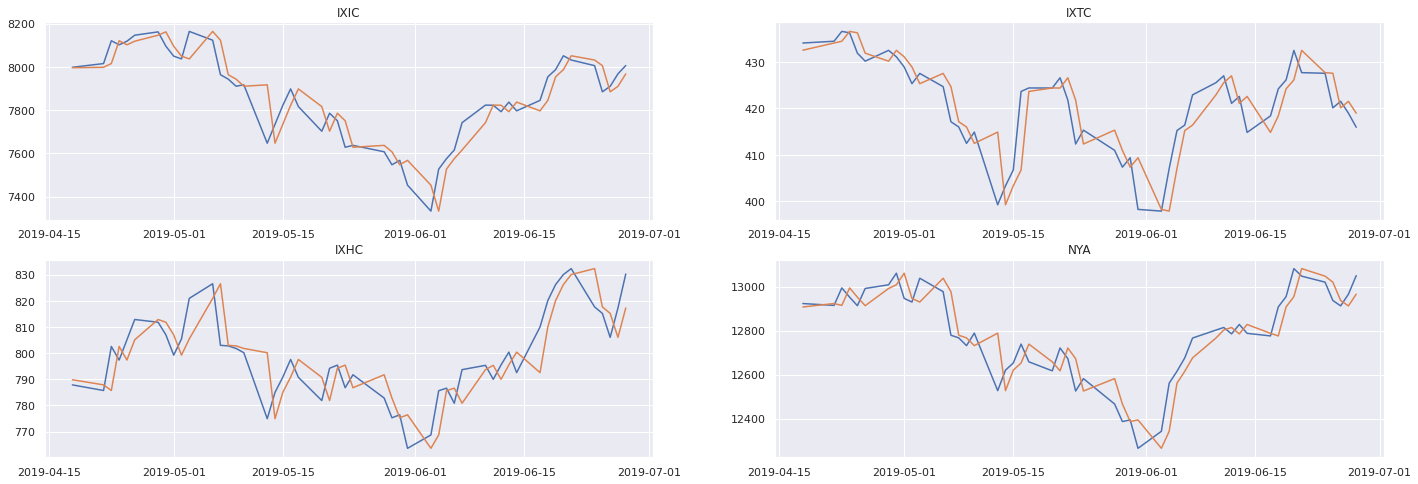

In [41]:
simple_predictor = SimplePredictor(X_lags_te, suffix='_l1')
results_dict['simple'] = model_metrics(X_lags_tr, Y_tr, X_lags_te, Y_te, targets_list, simple_predictor)

#### Горизонтальные "скачки" - это перенос предсказаний с пятницы на понедельник

In [42]:
pd.DataFrame(results_dict).T

,IXHC,IXIC,IXTC,NYA
simple,"{'RMSE': 9.5968, 'R2': 0.6516}","{'RMSE': 82.8468, 'R2': 0.8322}","{'RMSE': 5.4399, 'R2': 0.6928}","{'RMSE': 88.2798, 'R2': 0.8144}"


## **Регрессия на временных сдвигах**
#### TBD  

In [43]:
from sklearn.preprocessing import PowerTransformer

pt_features = PowerTransformer(method='yeo-johnson')

Y_tr_transformed = pd.DataFrame(pt_features.fit_transform(Y_tr), columns = Y_tr.columns)

In [44]:
print(pt_features.lambdas_)

[ 6.92830359  0.81334442  5.13878303  5.52635744  6.448508    7.43741536
  2.88513627  6.91747398 -2.82669919  3.35271814 11.41195978 12.1243507 ]


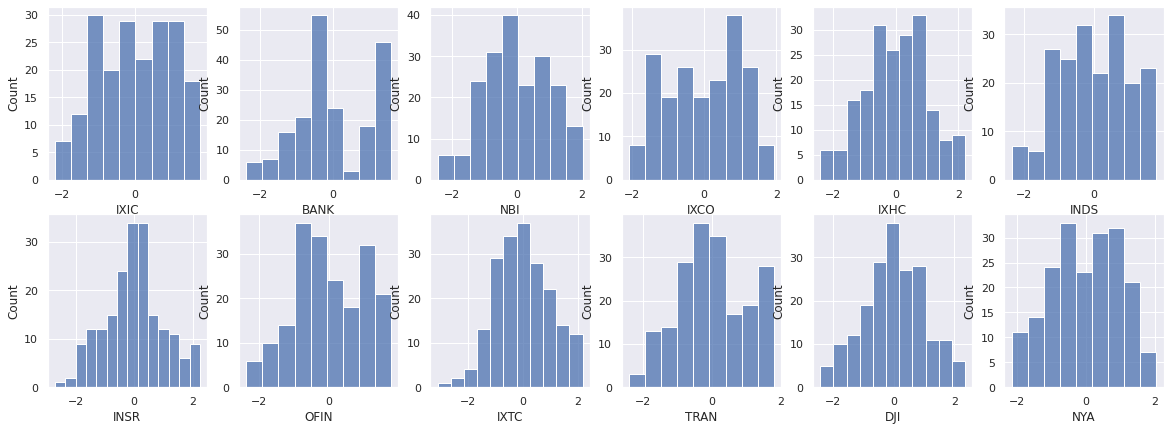

In [45]:
plt.figure(figsize=(20, 7))
for i, column in enumerate(Y_tr_transformed, 1):
    plt.subplot(2, 6, i)
    sns.histplot(Y_tr_transformed[column])

#### Видим, что преобразование Йо-Джонсона действительно привело распределения чуть ближе к нормальному виду.
#### Хотя остались переменные с двойными/тройными пиками на гистограмах.
#### Преобразование Бокса-Кокса к сожалению применить нельзя (оно давало картину получше), после применения PCA будут отрицатетельные переменные.
#### Попробуем уменьшить размерность.

In [46]:
X_lags_tr.shape

(196, 48)

In [47]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
pca.fit(X_lags_tr)

PCA(n_components=10)

In [48]:
np.cumsum(pca.explained_variance_ratio_)

array([0.83655872, 0.91389448, 0.9441928 , 0.96225373, 0.97682519,
       0.98332762, 0.98780187, 0.99167533, 0.9936087 , 0.99525039])

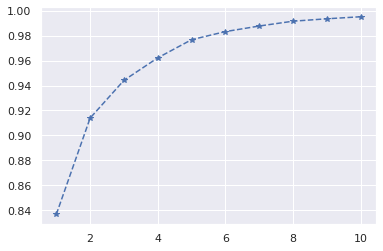

In [49]:
plt.plot(range(1, 11), np.cumsum(pca.explained_variance_ratio_), '*--');

In [50]:
pipeline = Pipeline(steps=[('transform', PowerTransformer(method='yeo-johnson')), 
                           ('pca', PCA(n_components=6)),
                           ('model', LassoCV(cv=TimeSeriesSplit(n_splits=6, max_train_size=90, test_size=10), random_state=0))])

model = TransformedTargetRegressor(regressor=pipeline, transformer=PowerTransformer(method='yeo-johnson'))
#Это что бы преобразовать целевую переменную перед обучением, а потом восстановить после предикта

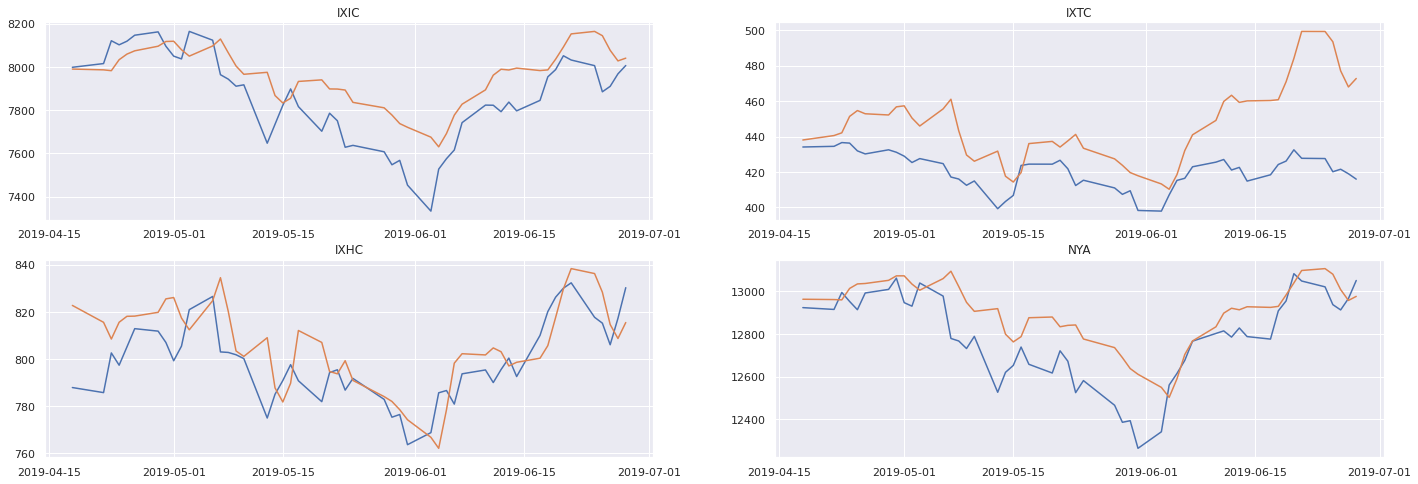

In [51]:
results_dict['lin_regression'] = model_metrics(X_lags_tr, Y_tr, X_lags_te, Y_te, targets_list, model)

In [52]:
pd.DataFrame(results_dict).T

,IXIC,IXTC,IXHC,NYA
simple,"{'RMSE': 82.8468, 'R2': 0.8322}","{'RMSE': 5.4399, 'R2': 0.6928}","{'RMSE': 9.5968, 'R2': 0.6516}","{'RMSE': 88.2798, 'R2': 0.8144}"
lin_regression,"{'RMSE': 148.948, 'R2': 0.4577}","{'RMSE': 32.2962, 'R2': -9.826}","{'RMSE': 14.6191, 'R2': 0.1914}","{'RMSE': 160.8866, 'R2': 0.3836}"


## **Полиномиальная регрессия на временных сдвигах**
#### Попробуем использовать полиномы, для нахождения нелинейных зависимостей.
#### Как идея на будущее: а что если из полиномов второй степени брать квадратные корни? Ведь если признак возрастает квадратично, а целевая переменная линейно, то полиномами мы взаимосвязь не найдем.

In [53]:
poly = PolynomialFeatures(2)
pca = PCA(n_components=10)
pca.fit(poly.fit_transform(X_lags_tr))

PCA(n_components=10)

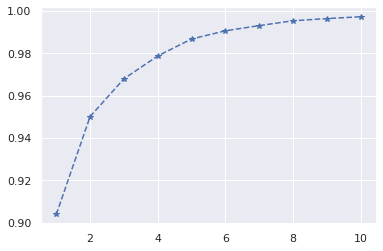

In [54]:
plt.plot(range(1, 11), np.cumsum(pca.explained_variance_ratio_), '*--');

In [55]:
pipeline = Pipeline(steps=[('poly', PolynomialFeatures(degree=2)),
                           ('transform', PowerTransformer(method='yeo-johnson')), 
                           ('pca', PCA(n_components=6)),
                           ('model', LassoCV(cv=TimeSeriesSplit(n_splits=2, max_train_size=5, test_size=1), random_state=0))])

model = TransformedTargetRegressor(regressor=pipeline, transformer=PowerTransformer(method='yeo-johnson'))

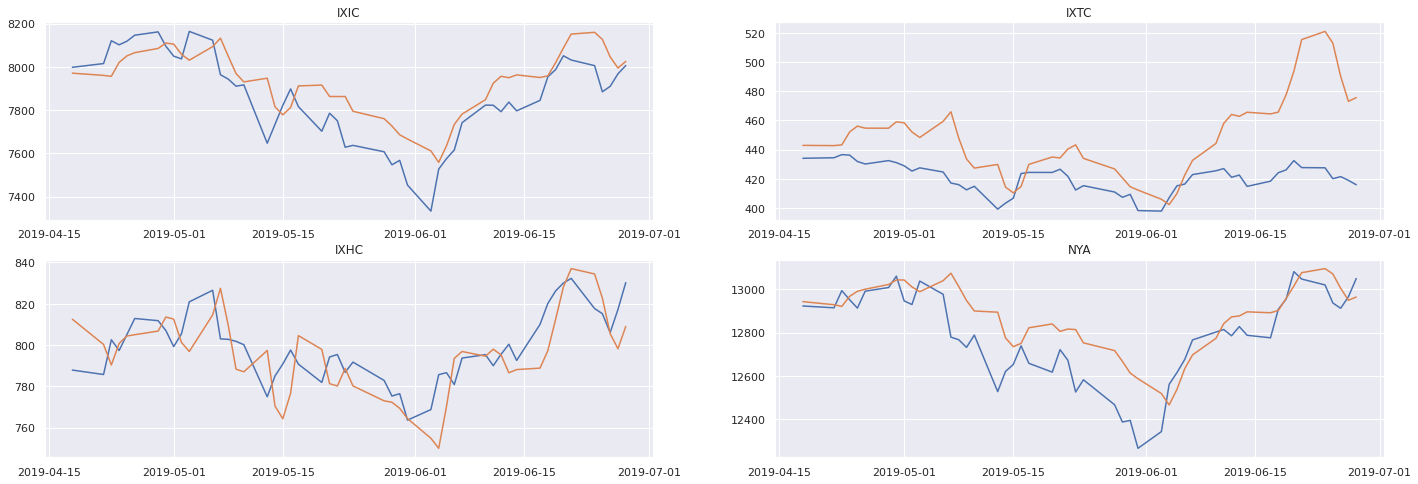

In [56]:
results_dict['polinomial_regression'] = model_metrics(X_lags_tr, Y_tr, X_lags_te, Y_te, targets_list, model)

In [57]:
pd.DataFrame(results_dict).T

,IXIC,IXTC,IXHC,NYA
simple,"{'RMSE': 82.8468, 'R2': 0.8322}","{'RMSE': 5.4399, 'R2': 0.6928}","{'RMSE': 9.5968, 'R2': 0.6516}","{'RMSE': 88.2798, 'R2': 0.8144}"
lin_regression,"{'RMSE': 148.948, 'R2': 0.4577}","{'RMSE': 32.2962, 'R2': -9.826}","{'RMSE': 14.6191, 'R2': 0.1914}","{'RMSE': 160.8866, 'R2': 0.3836}"
polinomial_regression,"{'RMSE': 126.5115, 'R2': 0.6088}","{'RMSE': 36.8831, 'R2': -13.1196}","{'RMSE': 14.5208, 'R2': 0.2023}","{'RMSE': 145.1616, 'R2': 0.4982}"


## **Теперь поработаем с относительными изменениями**

## **Начало тренда ?**
#### Попробуем предсказать движение цены, из предположения что сегодня будет продолжаться вчерашний тренд

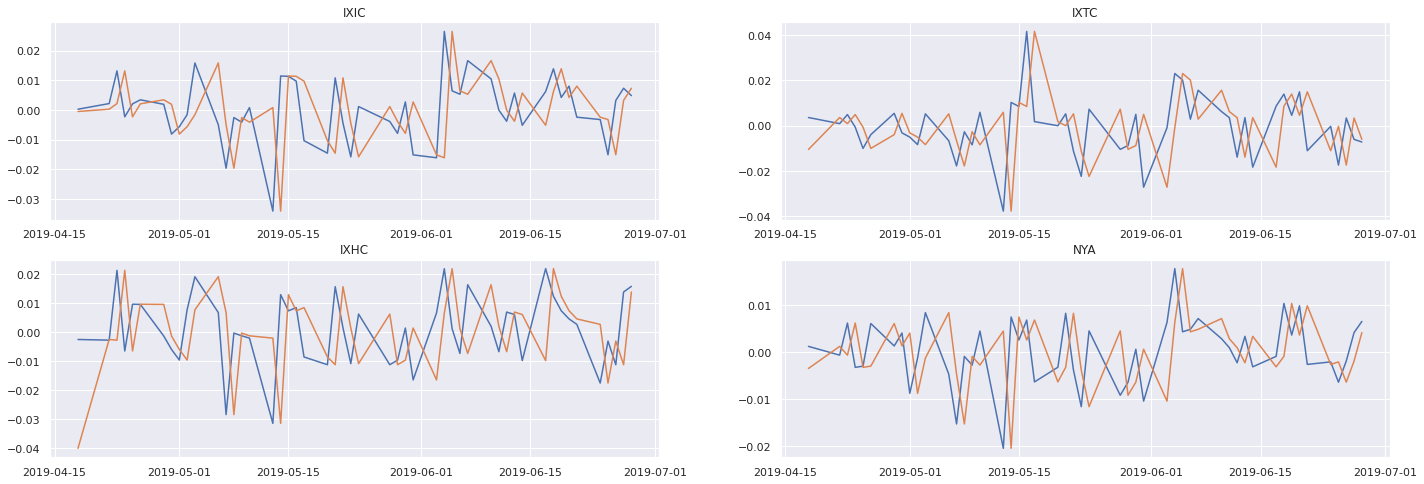

In [58]:
simple_predictor = SimplePredictor(X_rlags_te, suffix='_rl1')
results_relative_dict['simple_relative'] = model_metrics(X_rlags_tr, Y_rlags_tr, X_rlags_te, Y_rlags_te, targets_list, simple_predictor)

In [59]:
pd.DataFrame(results_relative_dict['simple_relative']).T

,RMSE,R2
IXIC,0.0148,-0.9231
IXTC,0.0183,-0.9443
IXHC,0.0180,-1.2597
NYA,0.0099,-1.0232


#### Конечно результаты никакие: дневной тренд меняется каждый день, и наши предсказания запаздывают на день.

## **ZEROS**
#### Логическое продолжение "самой простой модели": если цена не изменяется, то относительно изменение будет равно 0. Его (ноль) и будем использовать как предсказание.

#### DummyRegressor что-то отказался работать, так что написал сам:

In [60]:
class ZerosPredictor():
    def __init__(self):
        self.target = ''
    
    def fit(self, x_train, y_train):
        pass

    def predict(self, x_test):
        return pd.DataFrame(0.0, index=range(len(x_test)), columns=['prediction'])

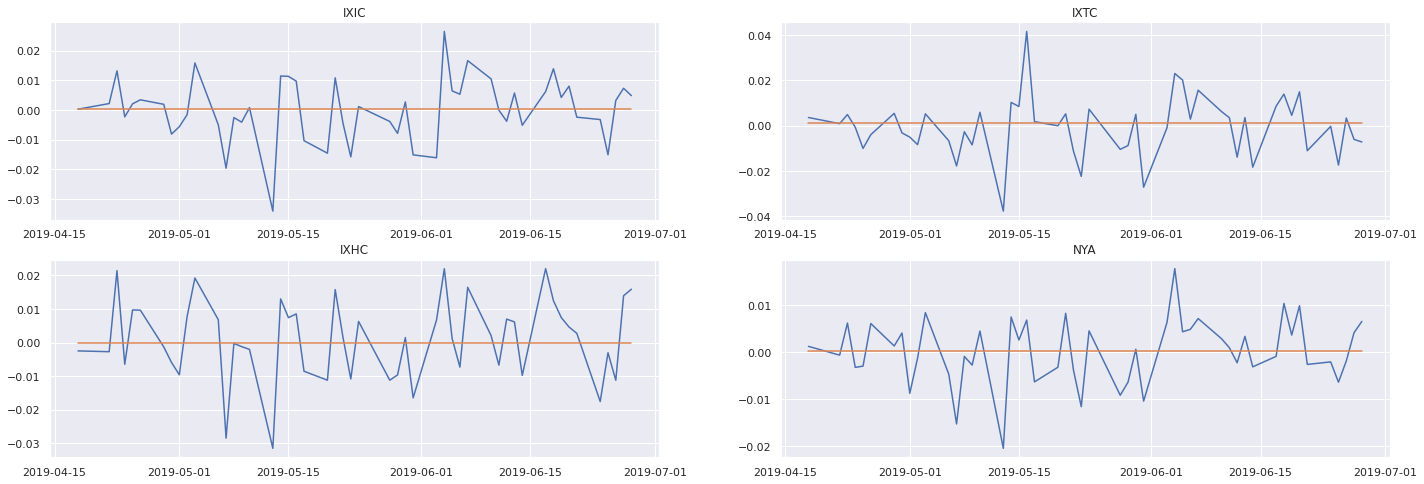

In [61]:
pipeline = Pipeline(steps=[('scaler', StandardScaler()), 
                           ('model', ZerosPredictor())])

model = TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler())

results_relative_dict['zeros'] = model_metrics(X_rlags_tr, Y_rlags_tr, X_rlags_te, Y_rlags_te, targets_list, model)

In [62]:
pd.DataFrame(results_relative_dict).T

,IXIC,IXTC,IXHC,NYA
simple_relative,"{'RMSE': 0.0148, 'R2': -0.9231}","{'RMSE': 0.0183, 'R2': -0.9443}","{'RMSE': 0.018, 'R2': -1.2597}","{'RMSE': 0.0099, 'R2': -1.0232}"
zeros,"{'RMSE': 0.0106, 'R2': -0.0004}","{'RMSE': 0.0132, 'R2': -0.0181}","{'RMSE': 0.012, 'R2': -0.0124}","{'RMSE': 0.0069, 'R2': -0.0002}"


#### Давольно логичный результат.

## **Регрессия на относительных изменениях за единицу времени со сдвигами** 

In [63]:
pipeline = Pipeline(steps=[#('poly', PolynomialFeatures(degree=2)),
                           ('transform', StandardScaler()), 
                           #('pca', PCA(n_components=6)),
                           ('model', LassoCV(cv=TimeSeriesSplit(n_splits=2, max_train_size=2, test_size=1), random_state=0))])

model = TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler())

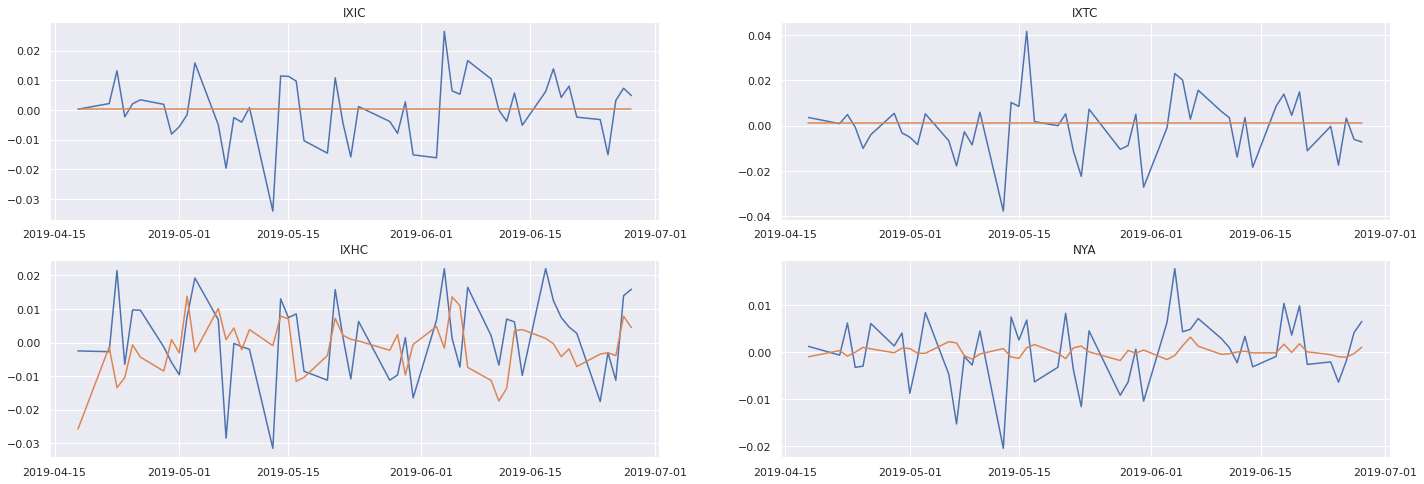

In [64]:
results_relative_dict['lin_regression'] = model_metrics(X_rlags_tr, Y_rlags_tr, X_rlags_te, Y_rlags_te, targets_list, model)

In [65]:
pd.DataFrame(results_relative_dict).T

,IXIC,IXTC,IXHC,NYA
simple_relative,"{'RMSE': 0.0148, 'R2': -0.9231}","{'RMSE': 0.0183, 'R2': -0.9443}","{'RMSE': 0.018, 'R2': -1.2597}","{'RMSE': 0.0099, 'R2': -1.0232}"
zeros,"{'RMSE': 0.0106, 'R2': -0.0004}","{'RMSE': 0.0132, 'R2': -0.0181}","{'RMSE': 0.012, 'R2': -0.0124}","{'RMSE': 0.0069, 'R2': -0.0002}"
lin_regression,"{'RMSE': 0.0106, 'R2': -0.0004}","{'RMSE': 0.0132, 'R2': -0.0181}","{'RMSE': 0.014, 'R2': -0.3646}","{'RMSE': 0.0071, 'R2': -0.0592}"


## **Регрессия на относительных изменениях за разные промежутки времени** 

In [66]:
pipeline = Pipeline(steps=[#('poly', PolynomialFeatures(degree=2)),
                           ('transform', StandardScaler()), 
                           #('pca', PCA(n_components=6)),
                           ('model', LassoCV(cv=TimeSeriesSplit(n_splits=2, max_train_size=5, test_size=1), random_state=0))])

model = TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler())

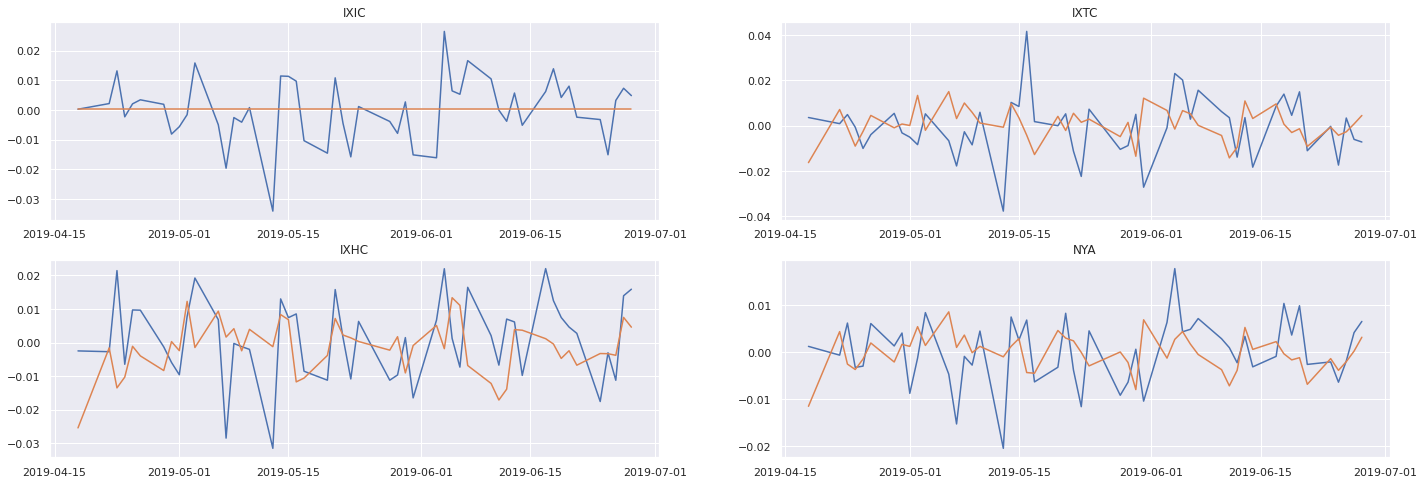

In [67]:
results_relative_dict['lin_regression_varied'] = model_metrics(X_variedr_tr, Y_rlags_tr, X_variedr_te, Y_rlags_te, targets_list, model)

In [68]:
pd.DataFrame(results_relative_dict).T

,IXIC,IXTC,IXHC,NYA
simple_relative,"{'RMSE': 0.0148, 'R2': -0.9231}","{'RMSE': 0.0183, 'R2': -0.9443}","{'RMSE': 0.018, 'R2': -1.2597}","{'RMSE': 0.0099, 'R2': -1.0232}"
zeros,"{'RMSE': 0.0106, 'R2': -0.0004}","{'RMSE': 0.0132, 'R2': -0.0181}","{'RMSE': 0.012, 'R2': -0.0124}","{'RMSE': 0.0069, 'R2': -0.0002}"
lin_regression,"{'RMSE': 0.0106, 'R2': -0.0004}","{'RMSE': 0.0132, 'R2': -0.0181}","{'RMSE': 0.014, 'R2': -0.3646}","{'RMSE': 0.0071, 'R2': -0.0592}"
lin_regression_varied,"{'RMSE': 0.0106, 'R2': -0.0004}","{'RMSE': 0.0156, 'R2': -0.4201}","{'RMSE': 0.0139, 'R2': -0.3558}","{'RMSE': 0.0079, 'R2': -0.2925}"


# **Выводы/Вопросы**  
* При смене модели метрики качества для разных тикеров менялись по разному, это означает что одни ряды лучше поддаются прогнозированию ?
* Для относительных изменений цен, отклонения предсказанных значений от 0 получается добится только при маленьком размере обучающих и валидационных выборках: скорее всего для предсказания цены на завтра на нужный данные дней за 5, всё что было раньше неважно. Для предсказания на практике каждый день модель нужно переобучать. Как при этом померить качество модели ?

# **Что пробовать дальше**  
* SVR
* VARIMA - ARIMA для многомерных временных рядов
* Нейронные сети: https://unit8.co/resources/training-forecasting-models/
* Более высокачастотные данные